Installing scikit-learn...
Installing pillow...
Creating synthetic audio dataset...
Created 32 wav files in data_speech/
Features shape: (32, 40)
Labels: ['angry' 'happy' 'neutral' 'sad']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input          │ (None, 1, 40)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_lstm (LSTM)  │ (None, 128)       │     86,528 │ mfcc_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ shared_lstm[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_out (Dense) │ (None, 4)         │        132 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ intensity_out       │ (None, 1)         │         33 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_out (Dense)   │ (None, 4)         │        260 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,529 (404.41 KB)

 Trainable params: 103,529 (404.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
4/4 - 5s - 1s/step - emotion_out_accuracy: 0.5600 - emotion_out_loss: 1.0294 - intensity_out_loss: 0.0863 - intensity_out_mse: 0.0927 - loss: 1.3807 - multi_out_loss: 0.1426 - multi_out_mse: 0.1476 - val_emotion_out_accuracy: 0.5714 - val_emotion_out_loss: 0.9383 - val_intensity_out_loss: 0.0758 - val_intensity_out_mse: 0.0758 - val_loss: 1.1618 - val_multi_out_loss: 0.1477 - val_multi_out_mse: 0.1477
Epoch 2/30
4/4 - 0s - 25ms/step - emotion_out_accuracy: 0.6400 - emotion_out_loss: 0.7832 - intensity_out_loss: 0.0471 - intensity_out_mse: 0.0543 - loss: 1.0798 - multi_out_loss: 0.1237 - multi_out_mse: 0.1331 - val_emotion_out_accuracy: 0.5714 - val_emotion_out_loss: 0.7915 - val_intensity_out_loss: 0.0421 - val_intensity_out_mse: 0.0421 - val_loss: 0.9627 - val_multi_out_loss: 0.1291 - val_multi_out_mse: 0.1291
Epoch 3/30
4/4 - 0s - 28ms/step - emotion_out_accuracy: 0.7600 - emotion_out_loss: 0.6296 - intensity_out_loss: 0.0233 - intensity_out_mse: 0.0296 - loss: 0.8870 - mu

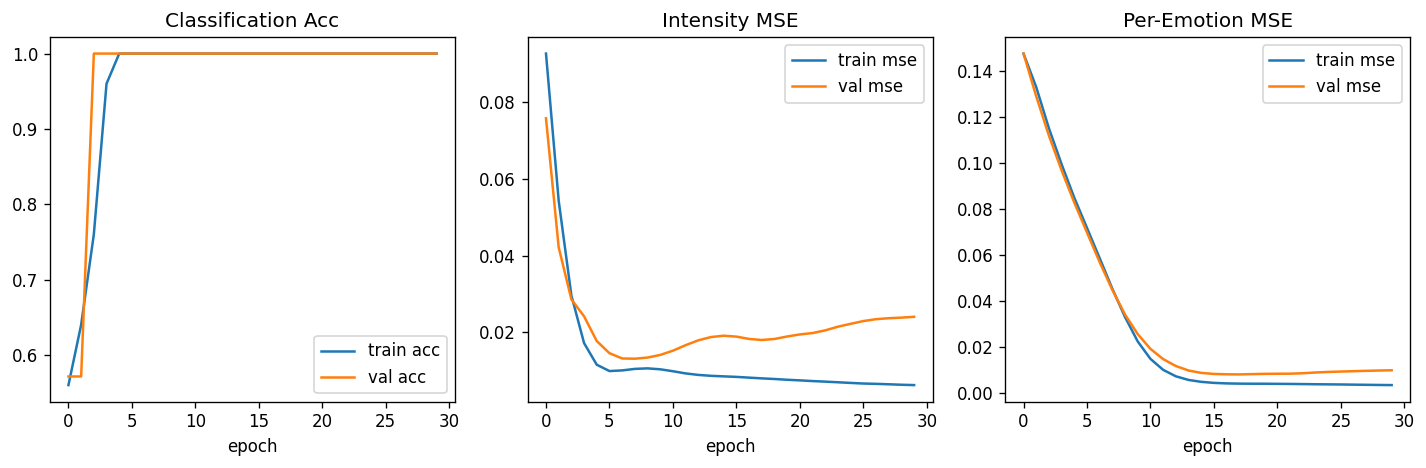


You can run predict_and_visualize(path) to see outputs & images.
Example: predict_and_visualize('data_speech/happy-0.wav')
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
=== Prediction Results ===
Predicted Emotion (class): happy 😄
Predicted Intensity (scalar): 0.897
Per-emotion scores (0-1):
  happy: 0.898 
  sad: 0.110  😢
  angry: 0.112 
  neutral: 0.088 
Saved images: happy-0_waveform.png happy-0_spectrogram.png happy-0_mfcc.png happy-0_face.png


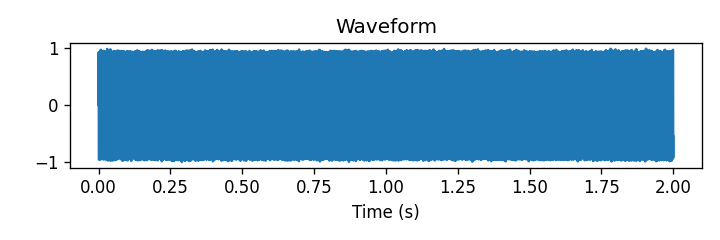

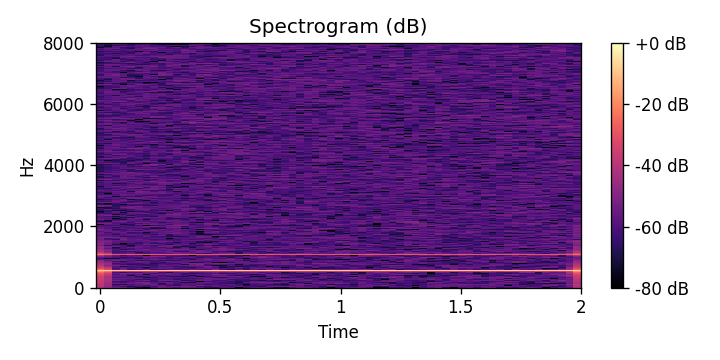

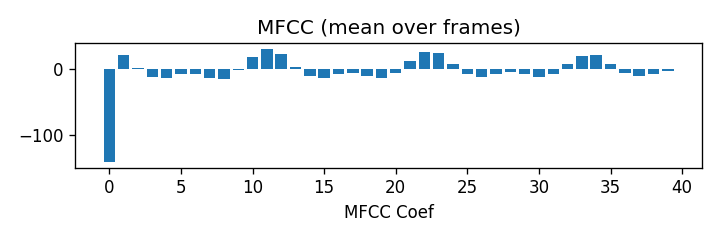

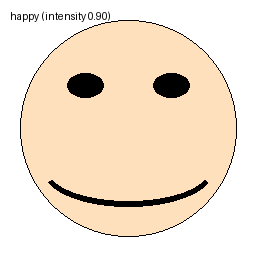

In [1]:
# Emotion Detection from Speech with Multi-Task Learning
# Combines classification, regression, and visualization

# Auto-install dependencies if needed
import sys, subprocess, os
def install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

for p in ["numpy","librosa","soundfile","tensorflow","scikit-learn","matplotlib","pillow"]:
    try:
        __import__(p)
    except Exception:
        print(f"Installing {p}...")
        install(p)

# Import required libraries
import numpy as np
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageDraw, ImageFont
import random
import io

# Configuration
DATA_DIR = "data_speech/"
EMOTIONS = ["happy","sad","angry","neutral"]
SAMPLE_RATE = 16000
DURATION = 2.0  # seconds
N_SAMPLES_PER_EMO = 8  # small dataset for demo
N_MFCC = 40
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Create synthetic audio dataset
os.makedirs(DATA_DIR, exist_ok=True)
print("Creating synthetic audio dataset...")

# Define distinct frequencies for each emotion
base_freq = {"happy":550,"sad":220,"angry":820,"neutral":330}
t = np.linspace(0, DURATION, int(SAMPLE_RATE*DURATION), endpoint=False)

# Generate audio files with slight variations
for emo in EMOTIONS:
    for i in range(N_SAMPLES_PER_EMO):
        f = base_freq[emo] + np.random.uniform(-20,20)
        amp = np.random.uniform(0.4,0.9)
        tone = amp * np.sin(2*np.pi*f*t)
        # Add harmonic and noise for realism
        tone += 0.2*amp*np.sin(2*np.pi*(f*2)*t)
        tone += 0.02*np.random.randn(len(t))
        filename = f"{emo}-{i}.wav"
        sf.write(os.path.join(DATA_DIR, filename), tone, SAMPLE_RATE)
print("Created", len(os.listdir(DATA_DIR)), "wav files in", DATA_DIR)

# Build features and targets
X_feats = []
Y_classes = []
Y_intensity = []          # single scalar per sample
Y_multiint = []          # vector per emotion

def extract_mfcc(path, n_mfcc=N_MFCC):
    """Extract MFCC features from audio file"""
    audio, sr = sf.read(path)
    if audio.ndim>1:
        audio = np.mean(audio, axis=1)
    # Ensure consistent length
    if len(audio) < int(SAMPLE_RATE*DURATION):
        audio = np.pad(audio, (0, int(SAMPLE_RATE*DURATION)-len(audio)))
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# Process all audio files
for file in sorted(os.listdir(DATA_DIR)):
    if not file.endswith(".wav"):
        continue
    path = os.path.join(DATA_DIR, file)
    emo = file.split("-")[0]
    feat = extract_mfcc(path)
    X_feats.append(feat)
    Y_classes.append(emo)

    # Create intensity targets
    intensity = float(np.random.uniform(0.65, 1.0))
    Y_intensity.append(intensity)
    v = np.random.uniform(0,0.18, size=len(EMOTIONS))
    idx = EMOTIONS.index(emo)
    v[idx] = intensity
    Y_multiint.append(v)

X = np.array(X_feats)
Y_classes = np.array(Y_classes)
Y_intensity = np.array(Y_intensity).astype(np.float32)
Y_multiint = np.array(Y_multiint).astype(np.float32)

print("Features shape:", X.shape)
print("Labels:", np.unique(Y_classes))

# Encode classification labels
le = LabelEncoder()
Y_cl = le.fit_transform(Y_classes)           # integer labels
Y_cl_cat = to_categorical(Y_cl, num_classes=len(EMOTIONS))

# Split data for training and testing
x_train, x_test, y_train_cl, y_test_cl, y_train_int, y_test_int, y_train_multi, y_test_multi = train_test_split(
    X, Y_cl_cat, Y_intensity, Y_multiint, test_size=0.2, random_state=RANDOM_SEED, stratify=Y_cl
)

# Reshape for RNN (timesteps=1, features)
x_train_r = np.expand_dims(x_train, axis=1)
x_test_r  = np.expand_dims(x_test, axis=1)

# Build multi-task model
inp = Input(shape=(1, X.shape[1]), name="mfcc_input")
x = layers.LSTM(128, name="shared_lstm")(inp)
x = layers.Dense(64, activation="relu")(x)

# Classification head
clf = layers.Dense(32, activation="relu")(x)
out_clf = layers.Dense(len(EMOTIONS), activation="softmax", name="emotion_out")(clf)

# Scalar intensity head (single value 0-1)
reg1 = layers.Dense(32, activation="relu")(x)
out_intensity = layers.Dense(1, activation="sigmoid", name="intensity_out")(reg1)

# Per-emotion regression vector head (each 0-1)
reg2 = layers.Dense(64, activation="relu")(x)
out_multi = layers.Dense(len(EMOTIONS), activation="sigmoid", name="multi_out")(reg2)

model = Model(inputs=inp, outputs=[out_clf, out_intensity, out_multi])
model.compile(optimizer="adam",
              loss={"emotion_out":"categorical_crossentropy",
                    "intensity_out":"mse",
                    "multi_out":"mse"},
              loss_weights={"emotion_out":1.0, "intensity_out":1.0, "multi_out":1.0},
              metrics={"emotion_out":"accuracy", "intensity_out":"mse", "multi_out":"mse"})
model.summary()

# Train the model
EPOCHS = 30
BATCH = 8
history = model.fit(x_train_r,
                    {"emotion_out": y_train_cl,
                     "intensity_out": y_train_int,
                     "multi_out": y_train_multi},
                    validation_data=(x_test_r,
                                     {"emotion_out": y_test_cl,
                                      "intensity_out": y_test_int,
                                      "multi_out": y_test_multi}),
                    epochs=EPOCHS,
                    batch_size=BATCH,
                    verbose=2)

# Plot training results
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(history.history['emotion_out_accuracy'], label='train acc')
plt.plot(history.history['val_emotion_out_accuracy'], label='val acc')
plt.title('Classification Acc')
plt.xlabel('epoch'); plt.legend()

plt.subplot(1,3,2)
plt.plot(history.history['intensity_out_mse'], label='train mse')
plt.plot(history.history['val_intensity_out_mse'], label='val mse')
plt.title('Intensity MSE'); plt.xlabel('epoch'); plt.legend()

plt.subplot(1,3,3)
plt.plot(history.history['multi_out_mse'], label='train mse')
plt.plot(history.history['val_multi_out_mse'], label='val mse')
plt.title('Per-Emotion MSE'); plt.xlabel('epoch'); plt.legend()
plt.tight_layout()
plt.show()

# Helper functions to save visualizations
def save_waveform_image(audio, sr, outpath):
    plt.figure(figsize=(6,2))
    plt.plot(np.linspace(0,len(audio)/sr, len(audio)), audio)
    plt.title("Waveform")
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

def save_spectrogram_image(audio, sr, outpath):
    S = librosa.stft(audio)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    plt.figure(figsize=(6,3))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.title("Spectrogram (dB)")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

def save_mfcc_image(mfcc_feat, outpath):
    plt.figure(figsize=(6,2))
    plt.bar(np.arange(len(mfcc_feat)), mfcc_feat)
    plt.title("MFCC (mean over frames)")
    plt.xlabel("MFCC Coef"); plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

# Draw cartoon face based on emotion and intensity
def draw_face(emotion, intensity, size=(256,256)):
    im = Image.new("RGB", size, (255,255,255))
    draw = ImageDraw.Draw(im)
    w,h = size

    # Face circle
    face_color = (255, 224, 189)
    draw.ellipse([20,20,w-20,h-20], fill=face_color, outline=(0,0,0))

    # Eyes
    ex = w//3; ey = h//3
    eye_w = 18; eye_h = 12

    # Adjust eyebrows for emotion
    if emotion == "angry":
        draw.line([(ex-25,ey-10),(ex+10,ey-5)], fill=(0,0,0), width=4)
        draw.line([(w-ex+25,ey-5),(w-ex-10,ey-10)], fill=(0,0,0), width=4)
    elif emotion == "sad":
        draw.line([(ex-25,ey+5),(ex+10,ey+10)], fill=(0,0,0), width=3)
        draw.line([(w-ex+25,ey+10),(w-ex-10,ey+5)], fill=(0,0,0), width=3)

    # Draw eyes
    draw.ellipse([ex-eye_w, ey-eye_h, ex+eye_w, ey+eye_h], fill=(0,0,0))
    draw.ellipse([w-ex-eye_w, ey-eye_h, w-ex+eye_w, ey+eye_h], fill=(0,0,0))

    # Mouth based on emotion
    mouth_w = w//3
    mouth_h = int(10 + 30*intensity)
    mx = w//2; my = int(h*2/3)

    if emotion == "happy":
        draw.arc([mx-mouth_w, my-mouth_h, mx+mouth_w, my+mouth_h], start=20, end=160, fill=(0,0,0), width=6)
    elif emotion == "sad":
        draw.arc([mx-mouth_w, my-mouth_h, mx+mouth_w, my+mouth_h], start=200, end=340, fill=(0,0,0), width=6)
    elif emotion == "angry":
        draw.line([(mx-mouth_w//2, my+10),(mx+mouth_w//2, my+10)], fill=(0,0,0), width=6)
    else:
        draw.line([(mx-mouth_w//2, my),(mx+mouth_w//2, my)], fill=(0,0,0), width=4)

    # Add text
    try:
        font = ImageFont.truetype("DejaVuSans.ttf", 14)
    except:
        font = ImageFont.load_default()
    draw.text((10,10), f"{emotion} (intensity {intensity:.2f})", fill=(0,0,0), font=font)
    return im

# Emoji mapping
emoji_map = {"happy":"😄", "sad":"😢", "angry":"😡", "neutral":"😐"}

# Main prediction and visualization function
def predict_and_visualize(audio_path):
    # Load and process audio
    audio, sr = sf.read(audio_path)
    if audio.ndim>1:
        audio = np.mean(audio, axis=1)

    # Extract features
    mfcc_feat = extract_mfcc(audio_path)
    x = np.expand_dims(mfcc_feat, axis=(0,1))  # (1,1,feat)

    # Predict
    pred_clf, pred_int, pred_multi = model.predict(x)
    pred_class_idx = np.argmax(pred_clf[0])
    pred_class = le.inverse_transform([pred_class_idx])[0]
    intensity_pred = float(pred_int[0][0])
    multi_pred = pred_multi[0]

    # Display results
    print("=== Prediction Results ===")
    print("Predicted Emotion (class):", pred_class, emoji_map.get(pred_class,""))
    print(f"Predicted Intensity (scalar): {intensity_pred:.3f}")
    print("Per-emotion scores (0-1):")
    for i,emo in enumerate(EMOTIONS):
        print(f"  {emo}: {multi_pred[i]:.3f} {' '+emoji_map.get(emo,'') if i==pred_class_idx else ''}")

    # Save visualizations
    base = os.path.splitext(os.path.basename(audio_path))[0]
    wf_path = f"{base}_waveform.png"
    sp_path = f"{base}_spectrogram.png"
    mf_path = f"{base}_mfcc.png"

    save_waveform_image(audio, sr, wf_path)
    save_spectrogram_image(audio, sr, sp_path)
    save_mfcc_image(mfcc_feat, mf_path)

    # Generate and save face image
    face_img = draw_face(pred_class, max(0.0, min(1.0,intensity_pred)))
    face_path = f"{base}_face.png"
    face_img.save(face_path)

    print("Saved images:", wf_path, sp_path, mf_path, face_path)

    # Display images if possible
    try:
        display(Image.open(wf_path))
        display(Image.open(sp_path))
        display(Image.open(mf_path))
        display(Image.open(face_path))
    except Exception:
        print("Images saved to disk. Open them to view.")

# Demo with a sample file
sample_file = os.path.join(DATA_DIR, f"happy-0.wav")
print("\nYou can run predict_and_visualize(path) to see outputs & images.")
print("Example: predict_and_visualize('{}')".format(sample_file))

# Auto-run demo if in interactive environment
try:
    predict_and_visualize(sample_file)
except Exception as e:
    print("Prediction demo failed:", e)
    print("But model was trained. Call predict_and_visualize(path) manually.")